In [52]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
from optuna.integration import lightgbm as lgb_op
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
now = datetime.datetime.now()

In [3]:
train_df = pd.read_csv('dataset/train_01.csv')
test_df = pd.read_csv('dataset/test_01.csv')

In [4]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns='id')

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

# RF

In [6]:
def objective_rf(trial):
    
    param_rf = {
    'n_estimators': 1800,
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_depth': trial.suggest_int('max_depth', 3, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'random_state': 18,
    'n_jobs': 2
    }
    
    rf = RandomForestClassifier(**param_rf)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [7]:
%%time

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=300, n_jobs=2)
print(study_rf.best_params)
print(study_rf.best_value)
rf_best_params = study_rf.best_params

[I 2020-08-11 08:31:13,733] Finished trial#0 resulted in value: 0.9116908135364511. Current best value is 0.9116908135364511 with parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 2}.
[I 2020-08-11 08:31:13,733] Finished trial#1 resulted in value: 0.9177053371684243. Current best value is 0.9177053371684243 with parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4}.
[I 2020-08-11 08:31:20,074] Finished trial#3 resulted in value: 0.9370838471023427. Current best value is 0.9370838471023427 with parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3}.
[I 2020-08-11 08:31:27,050] Finished trial#4 resulted in value: 0.9289879475363346. Current best value is 0.9370838471023427 with parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3}.
[I 2020-08-11 08:31:28,537] Finished trial#2 resulted in value: 0.9013001167994634.

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 3}
0.9370838471023427
CPU times: user 43min 40s, sys: 4min 21s, total: 48min 1s
Wall time: 19min 24s


In [8]:
rf = RandomForestClassifier(**rf_best_params)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=12)

In [9]:
train_score_rf = rf.score(x_train, y_train)
test_score_rf = rf.score(x_test, y_test)

rf_p = rf.predict(x_test)

acc_rf = accuracy_score(rf_p, y_test)
auc_rf = roc_auc_score(rf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rf, test_score_rf))
print('acc:{}, auc:{}'.format(acc_rf, auc_rf))

train score:0.924037954665261, test_score:0.9234932349323494
acc:0.9234932349323494, auc:0.961690071446169


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


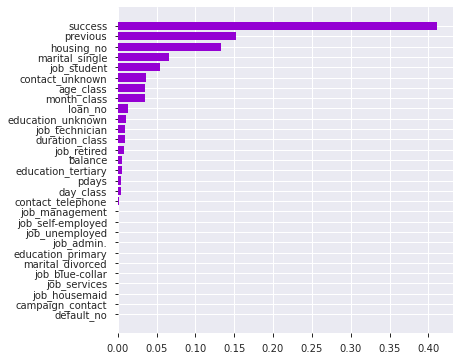

In [10]:
features = x_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [11]:
rf_name = 'models/RF_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(rf, open(rf_name, 'wb'))

In [12]:
pred_rf = rf.predict_proba(test_df)
rf_p = pd.DataFrame(pred_rf)
rf_p.head()

,0,1
0,0.542850,0.457150
1,0.946455,0.053545
2,0.938399,0.061601
3,0.945748,0.054252
4,0.895520,0.104480


# XGB

In [13]:
def objective_xgb(trial):
    
    param_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.05,
        'n_estimators': 1800,
        'early_stopping_rounds': 100,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18,
        'n_jobs': 2
    }
    
    xgb = XGBClassifier(**param_xgb)
    xgb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='logloss', verbose=False)
    predictions = xgb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [14]:
%%time

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=300, n_jobs=4)
print(study_xgb.best_params)
print(study_xgb.best_value)
xgb_best_params = study_xgb.best_params

[I 2020-08-11 08:50:44,213] Finished trial#2 resulted in value: 0.8233812810340526. Current best value is 0.8233812810340526 with parameters: {'max_depth': 3, 'min_child_weight': 4}.
[I 2020-08-11 08:50:57,644] Finished trial#3 resulted in value: 0.7272927286442499. Current best value is 0.8233812810340526 with parameters: {'max_depth': 3, 'min_child_weight': 4}.
[I 2020-08-11 08:51:02,135] Finished trial#0 resulted in value: 0.7369306457371425. Current best value is 0.8233812810340526 with parameters: {'max_depth': 3, 'min_child_weight': 4}.
[I 2020-08-11 08:51:12,361] Finished trial#1 resulted in value: 0.6898878994967005. Current best value is 0.8233812810340526 with parameters: {'max_depth': 3, 'min_child_weight': 4}.
[I 2020-08-11 08:51:19,988] Finished trial#4 resulted in value: 0.7419327887043256. Current best value is 0.8233812810340526 with parameters: {'max_depth': 3, 'min_child_weight': 4}.
[I 2020-08-11 08:51:20,519] Finished trial#5 resulted in value: 0.7557564902565266. C

{'max_depth': 3, 'min_child_weight': 4}
0.8233812810340526
CPU times: user 2h 30min 31s, sys: 4min 56s, total: 2h 35min 27s
Wall time: 26min 39s


In [15]:
xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [16]:
train_score_xgb = xgb_model.score(x_train, y_train)
test_score_xgb = xgb_model.score(x_test, y_test)

xgb_p = xgb_model.predict(x_test)

acc_xgb = accuracy_score(xgb_p, y_test)
auc_xgb = roc_auc_score(xgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))
print('acc:{}, auc:{}'.format(acc_xgb, auc_xgb))

train score:0.9325250395361097, test_score:0.9291512915129151
acc:0.9291512915129151, auc:0.8604420921544209


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


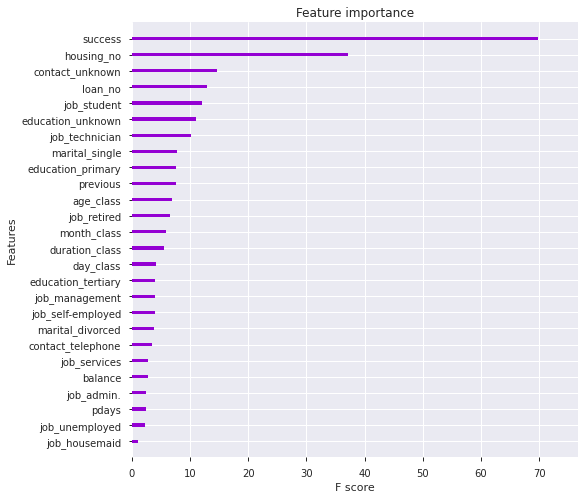

In [17]:
_, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(xgb_model,
                    ax=ax,
                    importance_type='gain',
                    color='darkviolet',
                    show_values=False)
plt.show()

In [18]:
xgb_name = 'models/XG_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(xgb_model, open(xgb_name, 'wb'))

In [19]:
pred_xgb = xgb_model.predict(test_df)
xgb_p = pd.DataFrame(pred_xgb)
xgb_p.head()

,0
0,1
1,0
2,0
3,0
4,0


# LGB

In [20]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [21]:
"""
def objective_lgb(trial):
    
    params_lgb = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': 1800,
        'learning_rate': 0.05,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_uniform('subsample', 0.3, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 35),
        'feature fraction': trial.suggest_uniform('feature fraction', 0.80, 0.95),
        'random_state': 18,
        'n_jobs': 2
    }
                          
    lgb = LGBMClassifier(**params_lgb)
    lgb = lgb.fit(x_train, y_train)
    
    predictions = lgb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score
    """

In [69]:
params_lgb_op = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations': 10000,
    'eta': 0.05,
    'seed': 18,
    'n_jobs': 2
}

In [70]:
lgb_op_model = lgb_op.train(params_lgb_op,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=100,
                     verbose_eval=200)


tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228418
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.226972



tune_feature_fraction, val_score: 0.226972:  14%|#4        | 1/7 [00:00<00:01,  3.05it/s][I 2020-08-11 12:32:25,285] Finished trial#0 resulted in value: 0.22697235592461093. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  14%|#4        | 1/7 [00:00<00:01,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228961
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.227214



tune_feature_fraction, val_score: 0.226972:  29%|##8       | 2/7 [00:00<00:01,  2.95it/s][I 2020-08-11 12:32:25,649] Finished trial#1 resulted in value: 0.22721371089534315. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  29%|##8       | 2/7 [00:00<00:01,  2.95it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.22707



tune_feature_fraction, val_score: 0.226972:  43%|####2     | 3/7 [00:01<00:01,  2.91it/s][I 2020-08-11 12:32:26,004] Finished trial#2 resulted in value: 0.2270699123271569. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  43%|####2     | 3/7 [00:01<00:01,  2.91it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.227216



tune_feature_fraction, val_score: 0.226972:  57%|#####7    | 4/7 [00:01<00:01,  2.85it/s][I 2020-08-11 12:32:26,387] Finished trial#3 resulted in value: 0.22721593668850343. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  57%|#####7    | 4/7 [00:01<00:01,  2.85it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.227607



tune_feature_fraction, val_score: 0.226972:  71%|#######1  | 5/7 [00:01<00:00,  2.76it/s][I 2020-08-11 12:32:26,758] Finished trial#4 resulted in value: 0.227607170533226. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  71%|#######1  | 5/7 [00:01<00:00,  2.76it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.228025



tune_feature_fraction, val_score: 0.226972:  86%|########5 | 6/7 [00:02<00:00,  2.81it/s][I 2020-08-11 12:32:27,097] Finished trial#5 resulted in value: 0.2280251132016893. Current best value is 0.22697235592461093 with parameters: {'feature_fraction': 0.4}.

tune_feature_fraction, val_score: 0.226972:  86%|########5 | 6/7 [00:02<00:00,  2.81it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.229064



tune_feature_fraction, val_score: 0.226972: 100%|##########| 7/7 [00:02<00:00,  2.69it/s]

tune_num_leaves, val_score: 0.226972:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.2355
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.228914



tune_num_leaves, val_score: 0.226972:   5%|5         | 1/20 [00:00<00:10,  1.79it/s][I 2020-08-11 12:32:28,116] Finished trial#0 resulted in value: 0.2289135758967026. Current best value is 0.2289135758967026 with parameters: {'num_leaves': 117}.

tune_num_leaves, val_score: 0.226972:   5%|5         | 1/20 [00:00<00:10,  1.79it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.230123



tune_num_leaves, val_score: 0.226972:  10%|#         | 2/20 [00:01<00:10,  1.71it/s][I 2020-08-11 12:32:28,766] Finished trial#1 resulted in value: 0.23012278619021653. Current best value is 0.2289135758967026 with parameters: {'num_leaves': 117}.

tune_num_leaves, val_score: 0.226972:  10%|#         | 2/20 [00:01<00:10,  1.71it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.230229



tune_num_leaves, val_score: 0.226972:  15%|#5        | 3/20 [00:01<00:10,  1.68it/s][I 2020-08-11 12:32:29,389] Finished trial#2 resulted in value: 0.2302294601821709. Current best value is 0.2289135758967026 with parameters: {'num_leaves': 117}.

tune_num_leaves, val_score: 0.226972:  15%|#5        | 3/20 [00:01<00:10,  1.68it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.228605



tune_num_leaves, val_score: 0.226972:  20%|##        | 4/20 [00:02<00:09,  1.73it/s][I 2020-08-11 12:32:29,923] Finished trial#3 resulted in value: 0.2286045808475399. Current best value is 0.2286045808475399 with parameters: {'num_leaves': 103}.

tune_num_leaves, val_score: 0.226972:  20%|##        | 4/20 [00:02<00:09,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227395
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.22634



tune_num_leaves, val_score: 0.226340:  25%|##5       | 5/20 [00:02<00:07,  1.95it/s][I 2020-08-11 12:32:30,279] Finished trial#4 resulted in value: 0.22634028498083403. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  25%|##5       | 5/20 [00:02<00:07,  1.95it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.230902



tune_num_leaves, val_score: 0.226340:  30%|###       | 6/20 [00:03<00:08,  1.69it/s][I 2020-08-11 12:32:31,063] Finished trial#5 resulted in value: 0.23090189942835707. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  30%|###       | 6/20 [00:03<00:08,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.229056
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.226884



tune_num_leaves, val_score: 0.226340:  35%|###5      | 7/20 [00:03<00:06,  1.87it/s][I 2020-08-11 12:32:31,464] Finished trial#6 resulted in value: 0.2268835270983601. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  35%|###5      | 7/20 [00:03<00:06,  1.87it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.229064
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.226945



tune_num_leaves, val_score: 0.226340:  40%|####      | 8/20 [00:04<00:05,  2.02it/s][I 2020-08-11 12:32:31,869] Finished trial#7 resulted in value: 0.22694468166621243. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  40%|####      | 8/20 [00:04<00:05,  2.02it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.2287
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.226748



tune_num_leaves, val_score: 0.226340:  45%|####5     | 9/20 [00:04<00:05,  2.12it/s][I 2020-08-11 12:32:32,284] Finished trial#8 resulted in value: 0.22674823442271147. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  45%|####5     | 9/20 [00:04<00:05,  2.12it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.230092



tune_num_leaves, val_score: 0.226340:  50%|#####     | 10/20 [00:05<00:05,  1.89it/s][I 2020-08-11 12:32:32,941] Finished trial#9 resulted in value: 0.23009200295629037. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  50%|#####     | 10/20 [00:05<00:05,  1.89it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227291
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.226917



tune_num_leaves, val_score: 0.226340:  55%|#####5    | 11/20 [00:05<00:04,  2.03it/s][I 2020-08-11 12:32:33,349] Finished trial#10 resulted in value: 0.22691657875603133. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  55%|#####5    | 11/20 [00:05<00:04,  2.03it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.22699
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.226681



tune_num_leaves, val_score: 0.226340:  60%|######    | 12/20 [00:06<00:03,  2.24it/s][I 2020-08-11 12:32:33,688] Finished trial#11 resulted in value: 0.22668061664535738. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  60%|######    | 12/20 [00:06<00:03,  2.24it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.228265



tune_num_leaves, val_score: 0.226340:  65%|######5   | 13/20 [00:06<00:03,  2.20it/s][I 2020-08-11 12:32:34,161] Finished trial#12 resulted in value: 0.22826468115644993. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  65%|######5   | 13/20 [00:06<00:03,  2.20it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.229566
[400]	valid_0's binary_logloss: 0.228337
Early stopping, best iteration is:
[498]	valid_0's binary_logloss: 0.228225



tune_num_leaves, val_score: 0.226340:  70%|#######   | 14/20 [00:07<00:02,  2.14it/s][I 2020-08-11 12:32:34,661] Finished trial#13 resulted in value: 0.22822450815881123. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  70%|#######   | 14/20 [00:07<00:02,  2.14it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.232096
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.227768



tune_num_leaves, val_score: 0.226340:  75%|#######5  | 15/20 [00:07<00:02,  2.07it/s][I 2020-08-11 12:32:35,177] Finished trial#14 resulted in value: 0.22776817065127344. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  75%|#######5  | 15/20 [00:07<00:02,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.233761
[400]	valid_0's binary_logloss: 0.231043
[600]	valid_0's binary_logloss: 0.230438
[800]	valid_0's binary_logloss: 0.230415
Early stopping, best iteration is:
[709]	valid_0's binary_logloss: 0.230353



tune_num_leaves, val_score: 0.226340:  80%|########  | 16/20 [00:08<00:02,  1.96it/s][I 2020-08-11 12:32:35,752] Finished trial#15 resulted in value: 0.2303533987758447. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  80%|########  | 16/20 [00:08<00:02,  1.96it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.229533



tune_num_leaves, val_score: 0.226340:  85%|########5 | 17/20 [00:08<00:01,  1.88it/s][I 2020-08-11 12:32:36,335] Finished trial#16 resulted in value: 0.2295331790784937. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  85%|########5 | 17/20 [00:08<00:01,  1.88it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228127
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.226622



tune_num_leaves, val_score: 0.226340:  90%|######### | 18/20 [00:09<00:00,  2.05it/s][I 2020-08-11 12:32:36,720] Finished trial#17 resulted in value: 0.22662191163079806. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  90%|######### | 18/20 [00:09<00:00,  2.05it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.232219
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.227817



tune_num_leaves, val_score: 0.226340:  95%|#########5| 19/20 [00:09<00:00,  2.06it/s][I 2020-08-11 12:32:37,197] Finished trial#18 resulted in value: 0.22781657830526245. Current best value is 0.22634028498083403 with parameters: {'num_leaves': 22}.

tune_num_leaves, val_score: 0.226340:  95%|#########5| 19/20 [00:09<00:00,  2.06it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228387
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.22667



tune_num_leaves, val_score: 0.226340: 100%|##########| 20/20 [00:10<00:00,  1.98it/s]

  0%|          | 0/10 [00:00<?, ?it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227131
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.226461



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:   0%|          | 0/10 [00:00<?, ?it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  10%|#         | 1/10 [00:00<00:03,  2.52it/s][I 2020-08-11 12:32:38,060] Finished trial#0 resulted in value: 0.22646095004957856. Current best value is 0.22646095004957856 with parameters: {'bagging_fraction': 0.923371208449977, 'bagging_freq': 7}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  10%|#         | 1/10 [00:00<00:03,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228512
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.227355



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  10%|#         | 1/10 [00:00<00:03,  2.52it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  20%|##        | 2/10 [00:00<00:03,  2.52it/s][I 2020-08-11 12:32:38,455] Finished trial#1 resulted in value: 0.22735529716490369. Current best value is 0.22646095004957856 with parameters: {'bagging_fraction': 0.923371208449977, 'bagging_freq': 7}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  20%|##        | 2/10 [00:00<00:03,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228418
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.227585



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  20%|##        | 2/10 [00:01<00:03,  2.52it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  30%|###       | 3/10 [00:01<00:02,  2.48it/s][I 2020-08-11 12:32:38,875] Finished trial#2 resulted in value: 0.22758465750827506. Current best value is 0.22646095004957856 with parameters: {'bagging_fraction': 0.923371208449977, 'bagging_freq': 7}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  30%|###       | 3/10 [00:01<00:02,  2.48it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.22711
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.226436



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  30%|###       | 3/10 [00:01<00:02,  2.48it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  40%|####      | 4/10 [00:01<00:02,  2.41it/s][I 2020-08-11 12:32:39,315] Finished trial#3 resulted in value: 0.22643558297685398. Current best value is 0.22643558297685398 with parameters: {'bagging_fraction': 0.9723393943095793, 'bagging_freq': 2}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  40%|####      | 4/10 [00:01<00:02,  2.41it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228004
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.226759



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  40%|####      | 4/10 [00:02<00:02,  2.41it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  50%|#####     | 5/10 [00:02<00:02,  2.43it/s][I 2020-08-11 12:32:39,718] Finished trial#4 resulted in value: 0.22675865318266894. Current best value is 0.22643558297685398 with parameters: {'bagging_fraction': 0.9723393943095793, 'bagging_freq': 2}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  50%|#####     | 5/10 [00:02<00:02,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227353
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.226368



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  50%|#####     | 5/10 [00:02<00:02,  2.43it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  60%|######    | 6/10 [00:02<00:01,  2.41it/s][I 2020-08-11 12:32:40,144] Finished trial#5 resulted in value: 0.2263683760927389. Current best value is 0.2263683760927389 with parameters: {'bagging_fraction': 0.8566838708435025, 'bagging_freq': 3}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  60%|######    | 6/10 [00:02<00:01,  2.41it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228171
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.226703



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  60%|######    | 6/10 [00:02<00:01,  2.41it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  70%|#######   | 7/10 [00:02<00:01,  2.40it/s][I 2020-08-11 12:32:40,561] Finished trial#6 resulted in value: 0.2267025297889229. Current best value is 0.2263683760927389 with parameters: {'bagging_fraction': 0.8566838708435025, 'bagging_freq': 3}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  70%|#######   | 7/10 [00:02<00:01,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228018
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.226823



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  70%|#######   | 7/10 [00:03<00:01,  2.40it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  80%|########  | 8/10 [00:03<00:00,  2.44it/s][I 2020-08-11 12:32:40,959] Finished trial#7 resulted in value: 0.226823102528188. Current best value is 0.2263683760927389 with parameters: {'bagging_fraction': 0.8566838708435025, 'bagging_freq': 3}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  80%|########  | 8/10 [00:03<00:00,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.228363
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.227452



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  80%|########  | 8/10 [00:03<00:00,  2.44it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  90%|######### | 9/10 [00:03<00:00,  2.45it/s][I 2020-08-11 12:32:41,362] Finished trial#8 resulted in value: 0.22745176593602465. Current best value is 0.2263683760927389 with parameters: {'bagging_fraction': 0.8566838708435025, 'bagging_freq': 3}.

tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  90%|######### | 9/10 [00:03<00:00,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.229001
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.228084



tune_bagging_fraction_and_bagging_freq, val_score: 0.226340:  90%|######### | 9/10 [00:04<00:00,  2.45it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340: 100%|##########| 10/10 [00:04<00:00,  2.48it/s][I 2020-08-11 12:32:41,753] Finished trial#9 resulted in value: 0.22808414412850808. Current best value is 0.2263683760927389 with parameters: {'bagging_fraction': 0.8566838708435025, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.226340: 100%|##########| 10/10 [00:04<00:00,  2.40it/s]

tune_feature_fraction, val_score: 0.226340:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227395
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.22634



tune_feature_fraction, val_score: 0.226340:  33%|###3      | 1/3 [00:00<00:00,  3.55it/s][I 2020-08-11 12:32:42,117] Finished trial#0 resulted in value: 0.22634028498083403. Current best value is 0.22634028498083403 with parameters: {'feature_fraction': 0.41600000000000004}.

tune_feature_fraction, val_score: 0.226340:  33%|###3      | 1/3 [00:00<00:00,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227914
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.226365



tune_feature_fraction, val_score: 0.226340:  67%|######6   | 2/3 [00:00<00:00,  3.23it/s][I 2020-08-11 12:32:42,493] Finished trial#1 resulted in value: 0.2263645132045758. Current best value is 0.22634028498083403 with parameters: {'feature_fraction': 0.41600000000000004}.

tune_feature_fraction, val_score: 0.226340:  67%|######6   | 2/3 [00:00<00:00,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227444
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226209



tune_feature_fraction, val_score: 0.226209: 100%|##########| 3/3 [00:01<00:00,  2.75it/s]

  0%|          | 0/20 [00:00<?, ?it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.226209:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227202
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.226466



tune_lambda_l1_and_lambda_l2, val_score: 0.226209:   0%|          | 0/20 [00:00<?, ?it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.226209:   5%|5         | 1/20 [00:00<00:05,  3.39it/s][I 2020-08-11 12:32:43,225] Finished trial#0 resulted in value: 0.22646645347513555. Current best value is 0.22646645347513555 with parameters: {'lambda_l1': 0.5072999305121059, 'lambda_l2': 0.6085760409571651}.

tune_lambda_l1_and_lambda_l2, val_score: 0.226209:   5%|5         | 1/20 [00:00<00:05,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227325
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.225981



tune_lambda_l1_and_lambda_l2, val_score: 0.225981:   5%|5         | 1/20 [00:00<00:05,  3.39it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225981:  10%|#         | 2/20 [00:00<00:05,  3.17it/s][I 2020-08-11 12:32:43,586] Finished trial#1 resulted in value: 0.2259813003693579. Current best value is 0.2259813003693579 with parameters: {'lambda_l1': 5.6811762388261576e-08, 'lambda_l2': 3.472254462764833e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225981:  10%|#         | 2/20 [00:00<00:05,  3.17it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227923
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226446



tune_lambda_l1_and_lambda_l2, val_score: 0.225981:  10%|#         | 2/20 [00:00<00:05,  3.17it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225981:  15%|#5        | 3/20 [00:01<00:05,  3.09it/s][I 2020-08-11 12:32:43,928] Finished trial#2 resulted in value: 0.22644620493561224. Current best value is 0.2259813003693579 with parameters: {'lambda_l1': 5.6811762388261576e-08, 'lambda_l2': 3.472254462764833e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225981:  15%|#5        | 3/20 [00:01<00:05,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226145
Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.225926



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  15%|#5        | 3/20 [00:01<00:05,  3.09it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  20%|##        | 4/20 [00:01<00:05,  2.69it/s][I 2020-08-11 12:32:44,413] Finished trial#3 resulted in value: 0.22592627215654942. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  20%|##        | 4/20 [00:01<00:05,  2.69it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227686
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.226198



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  20%|##        | 4/20 [00:01<00:05,  2.69it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  25%|##5       | 5/20 [00:01<00:05,  2.74it/s][I 2020-08-11 12:32:44,760] Finished trial#4 resulted in value: 0.22619838021275845. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  25%|##5       | 5/20 [00:01<00:05,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227457
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.22625



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  25%|##5       | 5/20 [00:02<00:05,  2.74it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  30%|###       | 6/20 [00:02<00:05,  2.77it/s][I 2020-08-11 12:32:45,117] Finished trial#5 resulted in value: 0.2262499589452788. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  30%|###       | 6/20 [00:02<00:05,  2.77it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227355
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.22622



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  30%|###       | 6/20 [00:02<00:05,  2.77it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  35%|###5      | 7/20 [00:02<00:04,  2.77it/s][I 2020-08-11 12:32:45,473] Finished trial#6 resulted in value: 0.22621963015734128. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  35%|###5      | 7/20 [00:02<00:04,  2.77it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.22764
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.226318



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  35%|###5      | 7/20 [00:02<00:04,  2.77it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  40%|####      | 8/20 [00:02<00:04,  2.77it/s][I 2020-08-11 12:32:45,833] Finished trial#7 resulted in value: 0.2263183501265389. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  40%|####      | 8/20 [00:02<00:04,  2.77it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227716
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226469



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  40%|####      | 8/20 [00:03<00:04,  2.77it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  45%|####5     | 9/20 [00:03<00:03,  2.81it/s][I 2020-08-11 12:32:46,180] Finished trial#8 resulted in value: 0.2264690422710771. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  45%|####5     | 9/20 [00:03<00:03,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227325
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.225981



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  45%|####5     | 9/20 [00:03<00:03,  2.81it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  50%|#####     | 10/20 [00:03<00:03,  2.76it/s][I 2020-08-11 12:32:46,555] Finished trial#9 resulted in value: 0.22598130738055588. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  50%|#####     | 10/20 [00:03<00:03,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226518
Early stopping, best iteration is:
[221]	valid_0's binary_logloss: 0.226462



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  50%|#####     | 10/20 [00:04<00:03,  2.76it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  55%|#####5    | 11/20 [00:04<00:03,  2.40it/s][I 2020-08-11 12:32:47,106] Finished trial#10 resulted in value: 0.2264624323019433. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  55%|#####5    | 11/20 [00:04<00:03,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227778
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226209



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  55%|#####5    | 11/20 [00:04<00:03,  2.40it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  60%|######    | 12/20 [00:04<00:03,  2.52it/s][I 2020-08-11 12:32:47,450] Finished trial#11 resulted in value: 0.22620919478665855. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  60%|######    | 12/20 [00:04<00:03,  2.52it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227294
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.22646



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  60%|######    | 12/20 [00:04<00:03,  2.52it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  65%|######5   | 13/20 [00:04<00:02,  2.57it/s][I 2020-08-11 12:32:47,820] Finished trial#12 resulted in value: 0.22645965242437432. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  65%|######5   | 13/20 [00:04<00:02,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227324
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226175



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  65%|######5   | 13/20 [00:05<00:02,  2.57it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  70%|#######   | 14/20 [00:05<00:02,  2.66it/s][I 2020-08-11 12:32:48,167] Finished trial#13 resulted in value: 0.2261749219546128. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  70%|#######   | 14/20 [00:05<00:02,  2.66it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226366
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.226228



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  70%|#######   | 14/20 [00:05<00:02,  2.66it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  75%|#######5  | 15/20 [00:05<00:02,  2.44it/s][I 2020-08-11 12:32:48,660] Finished trial#14 resulted in value: 0.22622806897199468. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  75%|#######5  | 15/20 [00:05<00:02,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227778
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.226209



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  75%|#######5  | 15/20 [00:06<00:02,  2.44it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  80%|########  | 16/20 [00:06<00:01,  2.55it/s][I 2020-08-11 12:32:49,006] Finished trial#15 resulted in value: 0.22620919607162507. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  80%|########  | 16/20 [00:06<00:01,  2.55it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227586
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.226496



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  80%|########  | 16/20 [00:06<00:01,  2.55it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  85%|########5 | 17/20 [00:06<00:01,  2.64it/s][I 2020-08-11 12:32:49,356] Finished trial#16 resulted in value: 0.22649626320815594. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  85%|########5 | 17/20 [00:06<00:01,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227325
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.225981



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  85%|########5 | 17/20 [00:06<00:01,  2.64it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  90%|######### | 18/20 [00:06<00:00,  2.68it/s][I 2020-08-11 12:32:49,714] Finished trial#17 resulted in value: 0.2259812984010946. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  90%|######### | 18/20 [00:06<00:00,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227325
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.225981



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  90%|######### | 18/20 [00:07<00:00,  2.68it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  95%|#########5| 19/20 [00:07<00:00,  2.70it/s][I 2020-08-11 12:32:50,080] Finished trial#18 resulted in value: 0.22598129391689561. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.

tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  95%|#########5| 19/20 [00:07<00:00,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.227506
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.22621



tune_lambda_l1_and_lambda_l2, val_score: 0.225926:  95%|#########5| 19/20 [00:07<00:00,  2.70it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.225926: 100%|##########| 20/20 [00:07<00:00,  2.75it/s][I 2020-08-11 12:32:50,428] Finished trial#19 resulted in value: 0.22621020662131436. Current best value is 0.22592627215654942 with parameters: {'lambda_l1': 5.0338005309371665, 'lambda_l2': 2.9139814271924417e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.225926: 100%|##########| 20/20 [00:07<00:00,  2.64it/s]

tune_min_child_samples, val_score: 0.225926:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226371
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.226033



tune_min_child_samples, val_score: 0.225926:  20%|##        | 1/5 [00:00<00:01,  2.59it/s][I 2020-08-11 12:32:50,897] Finished trial#0 resulted in value: 0.2260334059468309. Current best value is 0.2260334059468309 with parameters: {'min_child_samples': 5}.

tune_min_child_samples, val_score: 0.225926:  20%|##        | 1/5 [00:00<00:01,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226303
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.226067



tune_min_child_samples, val_score: 0.225926:  40%|####      | 2/5 [00:00<00:01,  2.40it/s][I 2020-08-11 12:32:51,387] Finished trial#1 resulted in value: 0.22606738874081353. Current best value is 0.2260334059468309 with parameters: {'min_child_samples': 5}.

tune_min_child_samples, val_score: 0.225926:  40%|####      | 2/5 [00:00<00:01,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226499
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.226226



tune_min_child_samples, val_score: 0.225926:  60%|######    | 3/5 [00:01<00:00,  2.33it/s][I 2020-08-11 12:32:51,847] Finished trial#2 resulted in value: 0.22622571124007834. Current best value is 0.2260334059468309 with parameters: {'min_child_samples': 5}.

tune_min_child_samples, val_score: 0.225926:  60%|######    | 3/5 [00:01<00:00,  2.33it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226385
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.226163



tune_min_child_samples, val_score: 0.225926:  80%|########  | 4/5 [00:01<00:00,  2.23it/s][I 2020-08-11 12:32:52,340] Finished trial#3 resulted in value: 0.22616271655988393. Current best value is 0.2260334059468309 with parameters: {'min_child_samples': 5}.

tune_min_child_samples, val_score: 0.225926:  80%|########  | 4/5 [00:01<00:00,  2.23it/s]

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.226813
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.226515



tune_min_child_samples, val_score: 0.225926: 100%|##########| 5/5 [00:02<00:00,  2.11it/s]


In [71]:
y_trainval_pred = lgb_op_model.predict(x_train, num_iteration=lgb_op_model.best_iteration)
y_test_pred = lgb_op_model.predict(x_test, num_iteration=lgb_op_model.best_iteration)

# ベストパラメータの取得
best_params = lgb_op_model.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

# 評価スコアの計算
r2_trainval = roc_auc_score(y_train, y_trainval_pred)
r2_test = roc_auc_score(y_test, y_test_pred)

print("r2_train:{0:.4}".format(r2_trainval))
print("r2_test:{0:.4}".format(r2_test))

  Params: 
    objective: binary
    metric: binary_logloss
    seed: 18
    n_jobs: 2
    learning_rate: 0.05
    lambda_l1: 5.0338005309371665
    lambda_l2: 2.9139814271924417e-05
    num_leaves: 22
    feature_fraction: 0.48000000000000004
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20
r2_train:0.8322
r2_test:0.7855


In [22]:
%%time

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100, n_jobs=4)

print(study_lgb.best_params)
print(study_lgb.best_value)
lgb_best_params = study_lgb.best_params

[I 2020-08-11 09:17:10,755] Finished trial#1 resulted in value: 0.7600196152172792. Current best value is 0.7600196152172792 with parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8521537596288304, 'colsample_bytree': 0.6926319281339657, 'min_data_in_leaf': 26, 'feature fraction': 0.8335737873239604}.
[I 2020-08-11 09:17:11,935] Finished trial#3 resulted in value: 0.7215389169986004. Current best value is 0.7600196152172792 with parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8521537596288304, 'colsample_bytree': 0.6926319281339657, 'min_data_in_leaf': 26, 'feature fraction': 0.8335737873239604}.
[I 2020-08-11 09:17:12,234] Finished trial#2 resulted in value: 0.7271488469601677. Current best value is 0.7600196152172792 with parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8521537596288304, 'colsample_bytree': 0.6926319281339657, 'min_data_in_leaf': 26, 'feature fraction': 0.8335737873239604}.
[I 2020-08-11 09:17:13,090] Finished tri

{'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5818824445730341, 'colsample_bytree': 0.7928832910093047, 'min_data_in_leaf': 35, 'feature fraction': 0.8268330547159679}
0.8353169329246792
CPU times: user 6min 10s, sys: 56.3 s, total: 7min 7s
Wall time: 1min 16s


In [23]:
lgb_model = LGBMClassifier(**lgb_best_params)
lgb_model.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.7928832910093047,
               feature fraction=0.8268330547159679, max_depth=3,
               min_child_weight=4, min_data_in_leaf=35,
               subsample=0.5818824445730341)

In [24]:
train_score_lgb = lgb_model.score(x_train, y_train)
test_score_lgb = lgb_model.score(x_test, y_test)

lgb_p = lgb_model.predict(x_test)

acc_lgb = accuracy_score(lgb_p, y_test)
auc_lgb = roc_auc_score(lgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_lgb, test_score_lgb))
print('acc:{}, auc:{}'.format(acc_lgb, auc_lgb))

train score:0.9305218766473379, test_score:0.9290282902829028
acc:0.9290282902829028, auc:0.8593235304105681


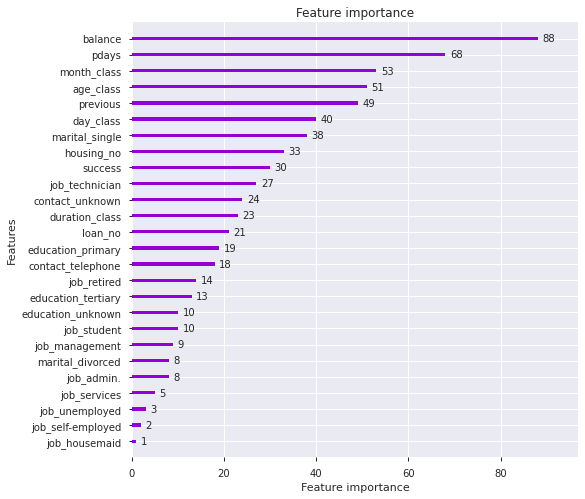

In [25]:
lgb.plot_importance(lgb_model, figsize=(8,8), color='darkviolet')

In [26]:
lgb_name = 'models/LGBM_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(lgb_model, open(lgb_name, 'wb'))

In [27]:
pred_lgb = lgb_model.predict_proba(test_df)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

,0,1
0,0.080229,0.919771
1,0.971200,0.028800
2,0.945897,0.054103
3,0.965297,0.034703
4,0.855384,0.144616


# CB

In [28]:
def objective_cb(trial):
    
    param_cb = {
        'iterations': 1800,
        'learning_rate': 0.05,
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50),
        'random_seed': 18
    }
    
    cb = CatBoostClassifier(**param_cb)
    cb.fit(x_train, y_train, verbose=False)
    predictions = cb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [29]:
%%time

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=100, n_jobs=4)

print(study_cb.best_params)
print(study_cb.best_value)
cb_best_params = study_cb.best_params

[I 2020-08-11 09:19:14,788] Finished trial#2 resulted in value: 0.7872722305060705. Current best value is 0.7872722305060705 with parameters: {'depth': 6, 'l2_leaf_reg': 5, 'od_type': 'Iter', 'od_wait': 32}.
[I 2020-08-11 09:19:18,721] Finished trial#3 resulted in value: 0.7638651415259867. Current best value is 0.7872722305060705 with parameters: {'depth': 6, 'l2_leaf_reg': 5, 'od_type': 'Iter', 'od_wait': 32}.
[I 2020-08-11 09:19:36,803] Finished trial#1 resulted in value: 0.7430920778028216. Current best value is 0.7872722305060705 with parameters: {'depth': 6, 'l2_leaf_reg': 5, 'od_type': 'Iter', 'od_wait': 32}.
[I 2020-08-11 09:19:53,870] Finished trial#4 resulted in value: 0.832892161678557. Current best value is 0.832892161678557 with parameters: {'depth': 3, 'l2_leaf_reg': 3, 'od_type': 'Iter', 'od_wait': 30}.
[I 2020-08-11 09:20:19,080] Finished trial#6 resulted in value: 0.7949447895100068. Current best value is 0.832892161678557 with parameters: {'depth': 3, 'l2_leaf_reg': 3

{'depth': 3, 'l2_leaf_reg': 8, 'od_type': 'IncToDec', 'od_wait': 47}
0.8395179691475987
CPU times: user 1h 31min 4s, sys: 14min 33s, total: 1h 45min 37s
Wall time: 19min 16s


In [33]:
cb_model = CatBoostClassifier(**cb_best_params)
cb_model.fit(x_train, y_train)

0:	learn: 0.6599480	total: 6.06ms	remaining: 6.06s
1:	learn: 0.6291839	total: 15ms	remaining: 7.48s
2:	learn: 0.6008277	total: 24.4ms	remaining: 8.09s
3:	learn: 0.5754523	total: 33.3ms	remaining: 8.3s
4:	learn: 0.5513976	total: 41.2ms	remaining: 8.21s
5:	learn: 0.5296229	total: 48.2ms	remaining: 7.99s
6:	learn: 0.5096343	total: 57.3ms	remaining: 8.13s
7:	learn: 0.4898074	total: 65.7ms	remaining: 8.15s
8:	learn: 0.4699613	total: 73.8ms	remaining: 8.13s
9:	learn: 0.4518677	total: 82.5ms	remaining: 8.17s
10:	learn: 0.4372567	total: 92.3ms	remaining: 8.29s
11:	learn: 0.4226687	total: 100ms	remaining: 8.27s
12:	learn: 0.4099497	total: 108ms	remaining: 8.21s
13:	learn: 0.3983480	total: 115ms	remaining: 8.09s
14:	learn: 0.3874055	total: 121ms	remaining: 7.98s
15:	learn: 0.3760046	total: 126ms	remaining: 7.78s
16:	learn: 0.3655435	total: 131ms	remaining: 7.56s
17:	learn: 0.3572055	total: 137ms	remaining: 7.45s
18:	learn: 0.3492596	total: 143ms	remaining: 7.39s
19:	learn: 0.3422976	total: 153ms

In [34]:
train_score_cb = cb.score(x_train, y_train)
test_score_cb = cb.score(x_test, y_test)

cb_p = cb_model.predict(x_test)

acc_cb = accuracy_score(cb_p, y_test)
auc_cb = roc_auc_score(cb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_cb, test_score_cb))
print('acc:{}, auc:{}'.format(acc_cb, auc_cb))

train score:0.9316816025303111, test_score:0.9289052890528905
acc:0.9289052890528905, auc:0.8526883847709488


In [ ]:
cb_name = 'models/CatBoost_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(cb_model, open(cb_name, 'wb'))

In [37]:
pred_cb = cb_model.predict_proba(test_df)
cb_p = pd.DataFrame(pred_cb)
cb_p.head()

,0,1
0,0.098381,0.901619
1,0.974592,0.025408
2,0.951896,0.048104
3,0.972561,0.027439
4,0.869990,0.130010


## submit

In [46]:
pred = pd.DataFrame({
    'RandomForest': rf_p[1],
    'XGBoost': xgb_p[0],
    'LightGBM': lgb_p[1],
    'CatBoost': cb_p[1]
})

pred.head()

,RandomForest,XGBoost,LightGBM,CatBoost
0,0.457150,1,0.919771,0.901619
1,0.053545,0,0.028800,0.025408
2,0.061601,0,0.054103,0.048104
3,0.054252,0,0.034703,0.027439
4,0.104480,0,0.144616,0.130010


In [47]:
pred['sum'] = pred.sum(axis=1)
pred['pred'] = [i/4 for i in pred['sum']]
pred.head()

,RandomForest,XGBoost,LightGBM,CatBoost,sum,pred
0,0.457150,1,0.919771,0.901619,3.278539,0.819635
1,0.053545,0,0.028800,0.025408,0.107753,0.026938
2,0.061601,0,0.054103,0.048104,0.163807,0.040952
3,0.054252,0,0.034703,0.027439,0.116394,0.029099
4,0.104480,0,0.144616,0.130010,0.379105,0.094776


In [48]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [41]:
# RandomForest

submission = pd.DataFrame({
    'ID':ID,
    'pred':rf_p[1]
})

file_name = 'submit/submit_RF' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [45]:
# XGBoost

submission = pd.DataFrame({
    'ID':ID,
    'pred':xgb_p[0]
})

file_name = 'submit/submit_XGBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [49]:
# LightGBM

submission = pd.DataFrame({
    'ID':ID,
    'pred':lgb_p[1]
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [39]:
# CatBoost

submission = pd.DataFrame({
    'ID':ID,
    'pred':cb_p[1]
})

file_name = 'submit/submit_CatBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)